Demo that shows the code in one file.

------------------------
## GOAL DETECTION
------------------------

The code below illustrates how the neural network for detecting the goal is created.

There are functions in the code below that are activated with flags. These are used to perform a one-time action, or for the script to do certain things while the model is being trained. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import requests
import cv2
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# path = "outputs/"
path = "Models/outputs5/"

# os.remove(f"{path}model.h5")
# os.remove(f"{path}model.json")
# os.remove(f"{path}params.txt")
# os.remove(f"{path}results.png")

### FLAGS ###
create_random_data_flag = False
show_sample_data_flag = False
show_results_flag = False

batch_size = 64
img_height = 100
img_width = 100
optimizer = 'adam'
epochs = 60

data_dir = r"C:\Users\thorl\OneDrive - Danmarks Tekniske Universitet\thor\3. Semester\Deep learning\project\DP-project\Data"

if create_random_data_flag is True:
    ## Creating random data
    path = r"C:\Users\thorl\OneDrive - Danmarks Tekniske Universitet\thor\3. Semester\Deep learning\project\DP-project\Data\Not football goal"

    for i in range(200):
        url = "https://picsum.photos/200/200/?random"
        response = requests.get(url)
        if response.status_code == 200:
            file_name = 'not_nicolas_{}.jpg'.format(i)
            file_path = path + "/" + file_name
            with open(file_path, 'wb') as f:
                print("saving: " + file_name)
                f.write(response.content)

### Dividing data into training and validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = ['Football goal', 'Not football goal']

### Visualise some of the training data
if show_sample_data_flag is True:
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        plt.show()

### Setting cache and prefetch, to optimise performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='softmax'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
  
])
model.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

xx = model.summary()

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Test model on sample image
print("Testing on VEO DATA ")
# img=cv2.imread(r"C:\Users\thorl\OneDrive - Danmarks Tekniske Universitet\thor\3. Semester\Deep learning\project\DP-project\sample_image_goal_from_ts.png")
img=cv2.imread(r"sample_image_goal_from_ts.png")
image=cv2.resize(img, (img_height,img_width))
image=np.expand_dims(image, axis=0) #input shape needs to be (1,width,height,channels)
predictions = model.predict(image)
class_index = np.argmax(predictions)
print("Model predictios :: ",predictions, " :: ",class_names[class_index])

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f'{path}results.png')

if show_results_flag is True:
    plt.show()

### Saving results
save = input("Want to save results? (y or n) \n")
if save == 'n':
    os.remove(f"{path}results.png")
    print("Model results not saved")
elif save == 'y':
    print("Model results saved")
else:
    print("invalid input")    

### Saving model
# serialize model to JSON
model_json = model.to_json()
with open(f"{path}model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{path}model.h5")
save = input("Want to save model? (y or n) \n")
if save == 'n':
    os.remove(f"{path}model.json")
    os.remove(f"{path}model.h5")
elif save == 'y':
    print("Model files saved")
else:
    print("invalid input")

with open(f"{path}params.txt", "w") as f:
    f.write('Model parameters!\n')
    f.write("Batch size: ")
    f.write(str(batch_size))
    f.write("\n")
    f.write("Image size: (height,width)")
    f.write(str(img_height))
    f.write(", ")
    f.write(str(img_width))
    f.write("\n")
    f.write("Model summery: ")
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write("\n")
    f.write("Number of epoch: ")
    f.write(str(epochs))
    f.write("\n")
    f.write("Optimizer: ")
    f.write(str(optimizer))
    f.write("\n")

  


The last part of the code gives the user the option to save the trained model, or discard it. It is also tested on a sample image of a goal to perform a quick test on the performance, however more tests will be made on the model.

To perform futher tests of the model, a script was made to quickly seperate VEO images into smaller images, where goals will be isolated in a single, smaller image, and the rest can be used to validate false positives.

In [ ]:
import image_slicer

image_slicer.slice(r'C:\Users\thorl\OneDrive - Danmarks Tekniske Universitet\thor\3. Semester\Deep learning\project\DP-project\Video_frames\left\video_2_00_26_20_left001.png', 14)

**IMAGE TAILING**

In [4]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import math
# import random
from typing import List
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
import sys, os
import heapq

img = Image.open(r"video_8_00_26_20_left001.png")

image = np.array(img)
# img.show()

frame_start_x = []
frame_start_y = []
frame_end_x = []
frame_end_y = []
prob = []
# 1261 331
# 1507 411
imgsize = [170 ,320]
grid_step = 20
print(image.shape)

image = image[200:880,300:1936]
img1 = Image.fromarray(image, 'RGB')
# img1.show()

path_to_dir = r"outputs7"
path_to_model = path_to_dir + '\model.json'
path_to_weight = path_to_dir + '\model.h5'

json_file = open(path_to_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path_to_weight)
print("Loaded model from disk")

### Compile the model
loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
blockPrint()
for x in range(math.floor((image.shape[1]/grid_step))-math.ceil(((imgsize[1]/grid_step)))):
    for y in range(math.floor((image.shape[0]/grid_step))-math.ceil(((imgsize[0]/grid_step)))):
        # print(x,y)
        frame_start_x.append(grid_step*x)
        frame_start_y.append(grid_step*y)
        frame_end_x.append(grid_step*x+imgsize[1])
        frame_end_y.append(grid_step*y+imgsize[0])
        color = image[(grid_step*y):(grid_step*y+imgsize[0]), (grid_step*x):(grid_step*x+imgsize[1])]
        color=np.expand_dims(color, axis=0) #input shape needs to be (1,width,height,channels)
        # print(color.shape)
        if (color.shape[1]<150 or color.shape[2]<150):
            continue
        predictions = loaded_model.predict(color)
        prob.append(predictions[0][0])
enablePrint()
print(len(prob))
print("zero sample: ", prob[0])
print("max element", max(prob))
maximum = max(prob)
index = prob.index(maximum)
print(index)
print("dimensions: ",frame_start_y[index], frame_end_y[index], frame_start_x[index], frame_end_x[index])
color = image[frame_start_y[index]:frame_end_y[index], frame_start_x[index]:frame_end_x[index]]
print("color shape", color.shape)
img1 = Image.fromarray(color, 'RGB')
# img1.show()


(2160, 3840, 3)
Loaded model from disk


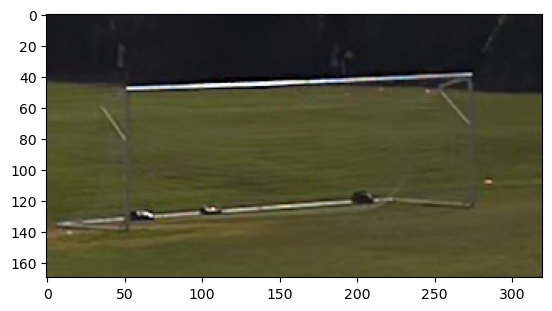

In [5]:
plt.imshow(img1)

------------------------
## FIELD LINES ESTIMATION
------------------------

**DETECTING MIDDLE OF THE GOAL**

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import numpy as np
from skimage.transform import (hough_line , hough_line_peaks)
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import numpy.ma as ma

def histogram_stretch(img_in):
    """
    Stretches the histogram of an image
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
    img_out = (img_float-min_val)*(1/(max_val-min_val))
    return img_as_ubyte(img_out)
    
def interval_fun (angle,val):
    return (angle>=val-0.05) & (angle<=val+0.05)

detected lines_hor: 1
detected lines_ver: 2
130.0 width of goal
intersection: 144.99999999999866 0.0
43.333333333333336 y middle
beam corner 144.99999999999866 0.0
130.0 dist middle


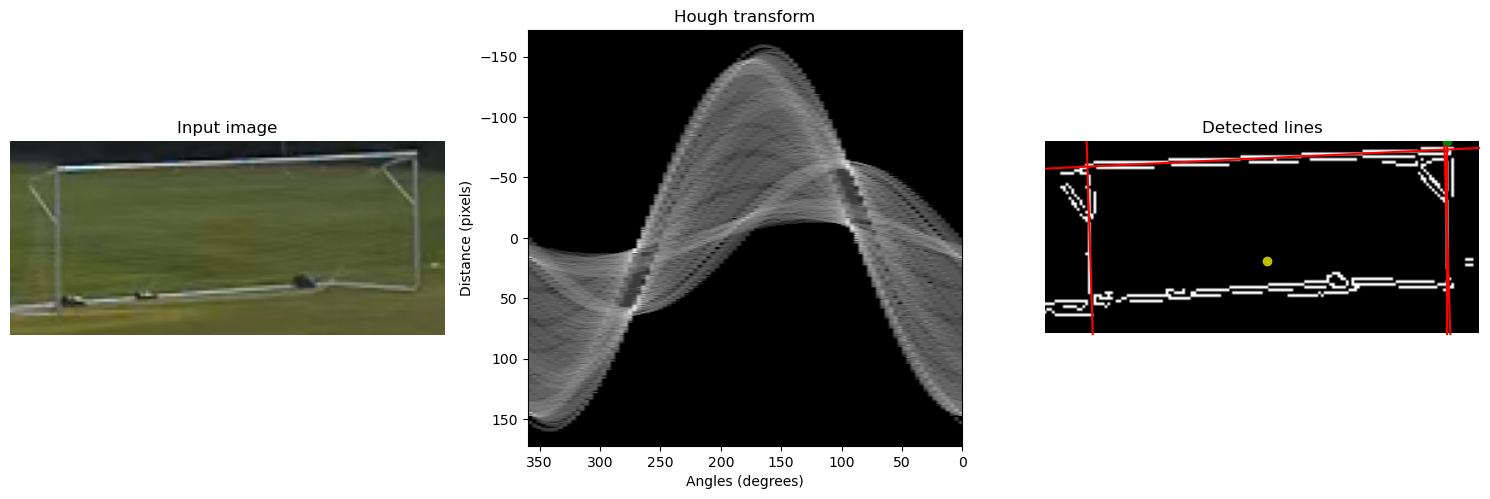

In [3]:

image_org = Image.open("goal8.png")
image = image_org.convert("L")
image1 = np.array(image)
image_org_1 = np.array(image_org)
image1 = histogram_stretch(image1)

image1 = cv2.Canny(image1,70,255)


tested_angles = np.linspace( 0, 2*np.pi , 100)

hspace, theta, dist = hough_line(image1, tested_angles)

h, q, d = hough_line_peaks(hspace, theta, dist)

#Example code from skimage documentation to plot the detected lines
angle_list=[]  #Create an empty list to capture all angles

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image_org_1, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image1, cmap='gray')

origin = np.array((0, image1.shape[1]))

lines_hor = 10
lines_ver = 10
thres = 0.1
thres_1 = 0.1

val_hor= np.pi/2
val_hor_2= 3*np.pi/2
val_ver = np.pi
val_ver_2 = 0  
val_ver_3 = 2* np.pi
# val_ver= np.pi/2

while (lines_hor > 1):
    thres = thres + 0.02
    _, angle1, dist1 = hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace)) 
    # arr = angle1[ (angle1 >= val-0.05) & (angle1 <= val+0.05) ]
    arr = angle1 [interval_fun(angle1,val_hor) | interval_fun(angle1,val_hor_2)]
    arr2 = dist1[interval_fun(angle1,val_hor) | interval_fun(angle1,val_hor_2)]
    lines_hor = len(arr) 
    dist2 = np.unique(arr2)
    lines_hor = len(dist2)
print("detected lines_hor:",len(dist2)) 

while (lines_ver > 2):
    thres_1 = thres_1 + 0.02
    _, angle1, dist1 = hough_line_peaks(hspace, theta, dist, threshold = thres_1 * np.max(hspace)) 
    arr = angle1 [interval_fun(angle1,val_ver) | interval_fun(angle1,val_ver_2) | interval_fun(angle1,val_ver_3)]
    arr2 = dist1[interval_fun(angle1,val_ver) | interval_fun(angle1,val_ver_2) | interval_fun(angle1,val_ver_3)]
    lines_ver = len(arr) 
    dist2 = np.unique(abs(arr2.round(-1)))
    lines_ver = len(dist2)
print("detected lines_ver:",len(dist2))

dist_arr = []

dist_prev = 0
for x, angle, dist1 in zip(*hough_line_peaks(hspace, theta, dist, threshold = thres_1 * np.max(hspace))):#, min_distance=110)):
    if(interval_fun(angle,val_ver) | interval_fun(angle,val_ver_2) | interval_fun(angle,val_ver_3)):
        if abs(abs(dist1)-abs(dist_prev))>20: 
            angle_list.append(angle) #Not for plotting but later calculation of angles
            dist_arr.append(abs(dist1))
            y0, y1 = (dist1 - origin * np.cos(angle)) / np.sin(angle)
            ax[2].plot(origin, (y0, y1), '-r')
            dist_prev = dist1
dist_middle = abs(abs(dist_arr[0]) - abs(dist_arr[1]))  
print(dist_middle,"width of goal")    
x0 = np.array([0,1])
y = np.divide(-np.cos(angle_list[0]),np.sin(angle_list[0]))*x0 + np.divide(dist_arr[0],np.sin(angle_list[0]))
a =(y[0] - y[1]) / (x0[0] - x0[1])
b = y[0] - (a * x0[0])
dist_prev = 1000
angle_list=[]
dist_arr=[]
for x, angle, dist in zip(*hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace))):#, min_distance=110)):
    if(interval_fun(angle,val_hor) | interval_fun(angle,val_hor_2)):
        if abs(abs(dist)-abs(dist_prev))>20: 

            dist_arr.append(abs(dist))
            angle_list.append(angle) #Not for plotting but later calculation of angles
            y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
            ax[2].plot(origin, (y0, y1), '-r')
            dist_prev = dist
x0 = np.array([0,1])
y = np.divide(-np.cos(angle_list),np.sin(angle_list))*x0 + np.divide(dist_arr,np.sin(angle_list))
a1 =(y[0] - y[1]) / (x0[0] - x0[1])
b1 = y[0] - (a1 * x0[0])
intersect_x = (b1 - b)/ (a - a1)
intersect_y = (a * intersect_x) + b
sign = 1
sign_y = 1
if (abs(intersect_x)> 120):
    sign = -1
    sign_y = -1
if intersect_x>0:
    sign_y = -1
print("intersection:",intersect_x,intersect_y)
y_middle = abs(abs(intersect_y)+(dist_middle/3))
print(y_middle,"y middle")
print("beam corner", intersect_x, intersect_y)
ax[2].plot(sign*dist_middle/2+abs(intersect_x), y_middle, 'yo')
ax[2].plot(abs(intersect_x), abs(intersect_y), 'go')
print(dist_middle, "dist middle")
ax[2].set_xlim(origin)
ax[2].set_ylim((image1.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

**PREPROCESSING**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_ubyte
from skimage.morphology import disk 
from skimage.morphology import erosion, dilation

In [2]:
def undistor_img(im_org):
    distortion = [3.670680675357433, 1.1612862793879029, 0.0, 
                0.0, 0.010907748126931006, 4.029813052720811, 
                2.357017484561505, 0.16278370795452082, 0.0, 
                0.0, 0.0, 0.0, 0.0, 0.0]

    # im_org = cv2.imread("detectiong_other_lines_field/video_4_00_45_25_left001.png")
    # (w,h) = np.shape(im_org)

    h, w, d = im_org.shape

    #intrinsic left camera matrix
    mtx = np.array([[1933.1962437237123, 0.0, 1836.8866309535802], 
                [0.0, 1933.74682448549, 878.6808564823706],
                [0.0, 0.0, 1.0]])

    distortion = np.array(distortion)

    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,distortion,(w,h),1,(w,h))

    dst = cv2.undistort(im_org, mtx, distortion, None, newcameramtx)

    #crop image in after undistort

    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]

    return dst

(1170, 2888, 3)


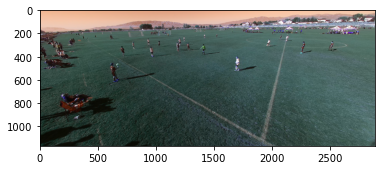

In [4]:
#Read image
im_org = cv2.imread("video_4_00_45_25_left001.png")
#Undistord image
im_org = undistor_img(im_org)

print(im_org.shape)
plt.imshow(im_org)

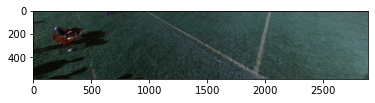

In [5]:
#take the half down part of the image
cropped_im = im_org[int(im_org.shape[0]/2):,:]
plt.imshow(cropped_im)

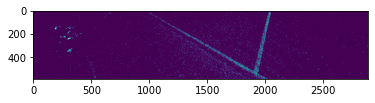

In [6]:
#extract rgb
r_comp = cropped_im[:, :, 0]
g_comp = cropped_im[:, :, 1]
b_comp = cropped_im[:, :, 2] 

thres = 120

# take only the white parts
white_im = (r_comp > thres) & (g_comp > thres) & (b_comp  > thres)

white_im = img_as_ubyte(white_im)

plt.imshow(white_im)

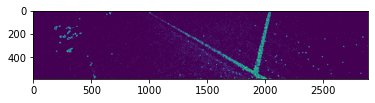

In [7]:
#Reduce noise with preprocessing techinques
footprint_e = disk(1.5)
footprint_d = disk(4)
ero_im = erosion(white_im, footprint_e)
dil_im = dilation(ero_im, footprint_d)
outline = np.logical_xor(dil_im, white_im)
outline = img_as_ubyte(outline)

plt.imshow(outline)

In [8]:
test = cropped_im.copy()

In [9]:
#function to find the intersection between two lines
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)

In [14]:
import math
#function to find slope of a line
def slope_line2(slope):

    alpha_1 = math.atan(slope)

    alpha_1_de = alpha_1*180/math.pi

    slope2 = math.tan(math.pi/2-alpha_1)

    return slope2

**PROCESSING**

Position of intersection: (1905, 522)


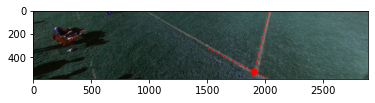

In [15]:
import math
thres = 100
n_lines = 20

## GETS THE FIRST LINE ##
while(n_lines > 1):
  lines = cv2.HoughLinesP(
              outline, # Input edge image
              100, # Distance resolution in pixels
              np.pi/180, # Angle resolution in radians
              threshold=thres, # Min number of votes for valid line
              minLineLength=500, # Min allowed length of line
              maxLineGap=30 # Max allowed gap between line for joining them
              )
  n_lines = len(lines)
  thres += 100


x1, y1, x2, y2 = lines[0][0]
slope = (y2-y1)/(x2-x1)

length_line = math.sqrt((y2-y1)**2+(x2-x1)**2)
slope2_d = slope_line2(slope)


## GETS THE SECOND LINE ##
got_line2 = False
length = 1200
while(got_line2 == False):
  lines2 = cv2.HoughLinesP(
                outline, # Input edge image
                100, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=10, # Min number of votes for valid line
                minLineLength=length, # Min allowed length of line
                maxLineGap=30 # Max allowed gap between line for joining them
                )
  if lines2 is None:
    got_line2 = False
    length -= 100
  else:
    got_line2 = True
    

for points in lines2:  
  x1,y1,x2,y2=points[0]
  
  if((x2-x1)!=0):
    slope2 = (y2-y1)/(x2-x1)
  # if (slope2_d + 0.9 > abs(slope2) > slope2_d - 0.9):
  if (slope2<0):       
    line2 = [x1,y1,x2,y2]

cv2.line(test,(line2[0],line2[1]),(line2[2],line2[3]),(255,0,0),4)

# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    
    # Draw the lines joing the points
    # On the original image
    cv2.line(test,(x1,y1),(x2,y2),(255,0,0),4)
    
x1,y1,x2,y2=lines[0][0]

x1_,y1_,x2_,y2_=line2

intersection = line_intersection(((x1, y1), (x2, y2)), ((x1_, y1_), (x2_, y2_)))
print(f"Position of intersection: {intersection}")

cv2.circle(test, intersection, 10, (255, 0 , 0), 40)
    
# Prints the result image
plt.imshow(test)

------------------------
## PERSPECTIVE TRANSFORMATION
------------------------

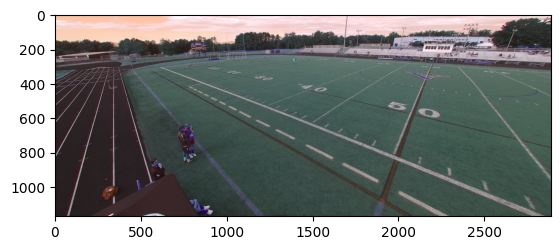

In [6]:
import numpy as np
import cv2
import matplotlib
import ffmpeg
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import PyQt5
import cv2
import numpy as np
#  jupyter nbconvert perspective_cv.ipynb --to python


frame = cv2.imread('video_12_00_26_20_left001.png')
#frame = cv2.imread('video_4_00_26_20_left001.png')
frame = undistor_img(frame)
%matplotlib inline

plt.imshow(frame)



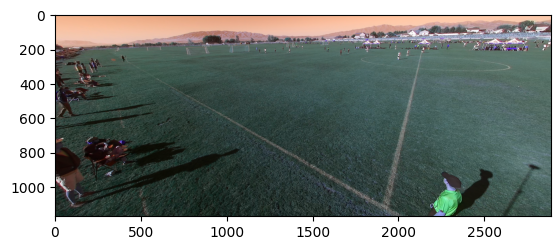

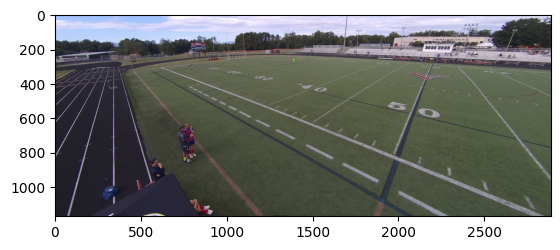

In [8]:
frame = cv2.imread('test.png')
im_dim = [2888,1170]
frame = cv2.resize(frame,(im_dim[0],im_dim[1]))
%matplotlib inline

plt.imshow(frame)

In [9]:
# warping section

"""    
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)

print (matrix)
result = cv2.warpPerspective(frame, matrix, (im_dim[0], im_dim[1]),flags=cv2.INTER_LINEAR)

plt.imshow(result)
"""
%matplotlib qt
plt.imshow(frame)
points = plt.ginput(4)
print(points)
%matplotlib inline
pts1 = np.float32([list(points[0]), # corner bottom right
                list(points[1]), # top,right
                list(points[2]), # top left
                list(points[3])]) # bottom left
print(pts1)

[(1964.0407873376619, 820.6525974025974), (2191.9628652597394, 288.83441558441564), (1359.4141639610386, 235.01948051948057), (615.5018262987012, 304.6623376623377)]
[[1964.0408   820.6526 ]
 [2191.963    288.8344 ]
 [1359.4142   235.01949]
 [ 615.50183  304.66232]]


In [10]:
print("finds points on close sideline from center of field to end")

# finds points on close sideline from center of field to end
vs = pts1[3]-pts1[0]
print(vs)
props = np.array([0,787,1076,1231,1310,np.linalg.norm(vs)]);
vs_base = vs/np.linalg.norm(vs)
print(vs_base)

S = []

for i in range(0,len(props)):
    S.append(pts1[0] + vs_base*props[i])
S = np.array(S)

print(S)
print("Finds points from top left corner to top right")
# Finds points from top left corner to top right
vl = pts1[2]-pts1[1]
print(vl)
props_l = np.array([0,245,432,585,740,np.linalg.norm(vl)]);
vl_base = vl/np.linalg.norm(vl)
print(vl_base)

L = []
for i in range(0,len(props_l)):
    L.append(pts1[1] + vl_base*props_l[i])
L = np.array(L)

print(L)
print("Finds points from bootom right corner to top right")
#Finds points from bootom right corner to top right
vc = pts1[1]-pts1[0]
print(vc)
props_c = np.array([0,442,520,562,np.linalg.norm(vc)]);
vc_base = vc/np.linalg.norm(vc)
print(vc_base)

C = []
for i in range(0,len(props_c)):
    C.append(pts1[0] + vc_base*props_c[i])
C = np.array(C)

print(C)
print("Finds points from bottom left corner to top left")

vg = pts1[2]-pts1[3]
print(vg)
props_g = np.array([0,353,454,614,np.linalg.norm(vg)])
vg_base = vg/np.linalg.norm(vg)
print(vg_base)

G = []
for i in range(0,len(props_g)):
    G.append(pts1[3] + vg_base*props_g[i])
G = np.array(G)

print(G)

finds points on close sideline from center of field to end
[-1348.539    -515.99023]
[-0.93396574 -0.35736248]
[[1964.0408   820.6526 ]
 [1229.0098   539.4083 ]
 [ 959.0936   436.13055]
 [ 814.329    380.73938]
 [ 740.54565  352.50775]
 [ 615.50183  304.66235]]
Finds points from top left corner to top right
[-832.5487    -53.814926]
[-0.9979174  -0.06450415]
[[2191.963    288.8344 ]
 [1947.4731   273.03088]
 [1760.8625   260.96863]
 [1608.1812   251.09949]
 [1453.504    241.10133]
 [1359.4142   235.01949]]
Finds points from bootom right corner to top right
[ 227.92212 -531.8182 ]
[ 0.39391938 -0.919145  ]
[[1964.0408   820.6526 ]
 [2138.153    414.3905 ]
 [2168.879    342.6972 ]
 [2185.4233   304.09308]
 [2191.963    288.8344 ]]
Finds points from bottom left corner to top left
[743.91235 -69.64284]
[ 0.99564654 -0.09320944]
[[ 615.50183  304.66232]
 [ 966.9651   271.7594 ]
 [1067.5254   262.34525]
 [1226.8289   247.43173]
 [1359.4142   235.01949]]


6 6
5 5


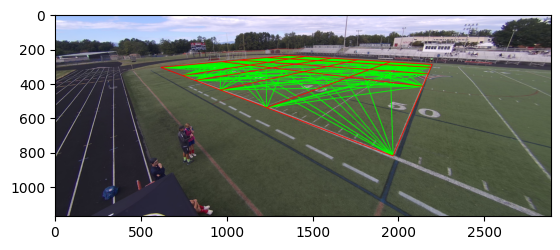

In [11]:
def drawline(PT1,PT2,frame,colour):
    #colour = (255, 0, 0)
    pt1 = (int(PT1[0]),int(PT1[1]))
    #print(pt1)
    pt2 = (int(PT2[0]),int(PT2[1]))
    #print(pt2)
    cv2.line(frame,pt1,pt2,colour,4)
    

# outer lines
drawline(L[0],L[-1],frame,(255,0,0))
drawline(G[0],G[-1],frame,(0,255,0))
drawline(S[0],S[-1],frame,(0,255,255))
drawline(C[0],C[-1],frame,(0,0,255))
# line grid
print(len(S),len(L))
print(len(C),len(G))

def generate_grid(S,G,L,C):
    lines = []
    for i in range(0,len(S)):
        for j in range(0,len(G)):
            drawline(S[i],G[j],frame,(0,255,0))
            lines.append([S[i],G[j]])
            drawline(S[i],C[j],frame,(0,255,0))
            lines.append([S[i],C[j]])
            drawline(L[i],G[j],frame,(0,255,0))
            lines.append([L[i],G[j]])
            drawline(L[i],C[j],frame,(0,255,0))
            lines.append([L[i],C[j]])
    """
    for i in range(0,len(S)):
        for j in range(0,len(L)):
            drawline(S[i],L[j],frame,(0,0,255))
            lines.append([S[i],L[j]])
    for i in range(0,len(C)):
        for j in range(0,len(G)):
            drawline(C[i],G[j],frame,(0,0,255))
            lines.append([C[i],G[j]])
    """
    for i in range(0,len(S)):
        drawline(S[i],L[i],frame,(255,0,0))
        lines.append([S[i],L[i]])

    for i in range(0,len(C)):
        drawline(C[i],G[i],frame,(255,0,0))
        lines.append([C[i],G[i]])

    return lines

lines = generate_grid(S,G,L,C)

'''
# external borders, uncomment only for visualization
for i in range(0,len(S)):
    drawline(S[i],L[i],frame,(255,0,0))

for i in range(0,len(C)):
    drawline(C[i],G[i],frame,(255,0,0))
'''

plt.imshow(frame)


In [12]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)

wf =68 # wid
hlf = 50
c_w = 18
lengths = [0,10,20,30,40,50]
widths = [0,25,25+c_w/2,25+c_w,wf]

S_real = []
L_real = []
G_real = []
C_real = []

for i in range(0,len(lengths)):
    S_real.append([lengths[i],0])
    L_real.append([lengths[i],wf])
for i in range(0,len(widths)):
    G_real.append([0,widths[i]])
    C_real.append([50,widths[i]])
lines_real = generate_grid(S_real,G_real,L_real,C_real)

S_real = np.array(S_real)
L_real = np.array(L_real)
G_real = np.array(G_real)
C_real = np.array(C_real)
print("check colums: ")
print(len(S_real),len(S))
print(len(L_real),len(L))
print(len(G_real),len(G))
print(len(C_real),len(C))
print(len(lines),len(lines_real))

check colums: 
6 6
6 6
5 5
5 5
131 131


In [13]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
point = Point(0.5, 0.5)
polygon = Polygon([(points[0][0]+5,points[0][1]+5),(points[1][0]+5,points[1][1]-5),(points[2][0]-5,points[2][1]-5),(points[3][0]-5,points[3][1]+5)])
print(polygon.contains(point))

points_real =[(hlf,0),(hlf,wf),(0,wf),(0,0)]

False


2585 2585


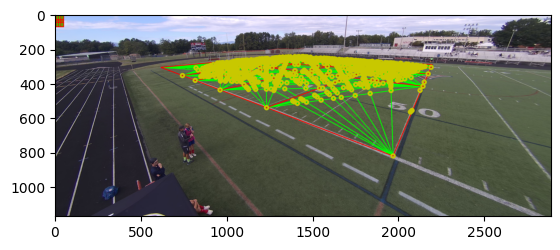

In [14]:
#for loop starts here
#provide intersection list to function
def find_intersections(lines,points,lines_real,points_real):
    #points_addition = 
    polygon = Polygon(points)
    polygon_real = Polygon(points_real)
    itscs = []
    itscs_real = []
    for i in range(0,len(lines)):
        # starting line
        b_line = lines[i]
        PT1 = b_line[0]
        PT2 = b_line[1]

        b_line_r = lines_real[i]
        PT1r = b_line_r[0]
        PT2r = b_line_r[1]

        for j in range(i,len(lines)):
            #points 3 and 4 represent a vertical line
            PT3 = lines[j][0]
            PT4 = lines[j][1]
            PT3r= lines_real[j][0]
            PT4r= lines_real[j][1]

            x1 = PT1[0]
            y1 = PT1[1]
            x2 = PT2[0]
            y2 = PT2[1]
            x1_ = PT3[0]
            y1_ = PT3[1]
            x2_ = PT4[0]
            y2_ = PT4[1]

            x1r = PT1r[0]
            y1r = PT1r[1]
            x2r = PT2r[0]
            y2r = PT2r[1]
            x1_r = PT3r[0]
            y1_r = PT3r[1]
            x2_r = PT4r[0]
            y2_r = PT4r[1]
            
            try:
                intersection = line_intersection(((x1, y1), (x2, y2)), ((x1_, y1_), (x2_, y2_)))
                intersection_real = line_intersection(((x1r, y1r), (x2r, y2r)), ((x1_r, y1_r), (x2_r, y2_r)))
                point = Point(intersection[0], intersection[1])
                point_r = Point(intersection_real[0], intersection_real[1])
                if(polygon.contains(point)):
                    cv2.circle(frame,intersection,10,(200,200,0),10)
                    itscs.append(intersection)
                    itscs_real.append(intersection_real)
            except:
                continue
    
    itscs = np.array(itscs)
    itscs_real = np.array(itscs_real)
    return itscs,itscs_real

itsec_pixl,itsec_real = find_intersections(lines,points,lines_real,points_real)
plt.imshow(frame)
print(len(itsec_pixl),len(itsec_real))




In [52]:
import tensorflow as tf
from tensorflow import keras
# model
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='sigmoid')) # relu has to be avoided for last layer
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='mse', #used to be mse, lets see if we get an improvement
              metrics=['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                192       
                                                                 
 dense_22 (Dense)            (None, 16)                1040      
                                                                 
 dense_23 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,266
Trainable params: 1,266
Non-trainable params: 0
_________________________________________________________________


In [53]:
from sklearn.model_selection import train_test_split

wrld_coord = np.divide(itsec_real,np.array([hlf,wf])) #normalisation step
pixl_coord = np.divide(itsec_pixl,np.array(im_dim)) #normalisation step
print(wrld_coord[10],pixl_coord[10])

p_train, p_test,w_train, w_test = train_test_split(pixl_coord,wrld_coord ,
                                   test_size=0.5, 
                                   shuffle=True)
  
batch = 16# tested with 10, maybe 32 helps a little more
eps = 75
history = model.fit(p_train,w_train,validation_split = 0.2,batch_size=batch, epochs=eps)
#keras.backend.set_value(model.optimizer.learning_rate, 0.001)
#model.fit(pixl_coord,wrld_coord,batch_size=batch, epochs=eps)

[0.         1.41176471] [0.63642659 0.24957265]
Epoch 1/75
65/65 [==============================] - 2s 9ms/step - loss: 0.7927 - accuracy: 0.6515 - val_loss: 0.7985 - val_accuracy: 0.7027
Epoch 2/75
65/65 [==============================] - 0s 5ms/step - loss: 0.7633 - accuracy: 0.6457 - val_loss: 0.7677 - val_accuracy: 0.5869
Epoch 3/75
65/65 [==============================] - 0s 5ms/step - loss: 0.7634 - accuracy: 0.6031 - val_loss: 0.7789 - val_accuracy: 0.6062
Epoch 4/75
65/65 [==============================] - 0s 6ms/step - loss: 0.7491 - accuracy: 0.5634 - val_loss: 0.7631 - val_accuracy: 0.5792
Epoch 5/75
65/65 [==============================] - 0s 5ms/step - loss: 0.7506 - accuracy: 0.5915 - val_loss: 0.7665 - val_accuracy: 0.5830
Epoch 6/75
65/65 [==============================] - 0s 5ms/step - loss: 0.7511 - accuracy: 0.6137 - val_loss: 0.7699 - val_accuracy: 0.6255
Epoch 7/75
65/65 [==============================] - 0s 5ms/step - loss: 0.7456 - accuracy: 0.5905 - val_loss: 0.

In [54]:
test = np.divide(np.array([[1390,289]]),np.array(im_dim))
#print(test)
test_result = model.predict(test)
#print(test_result)
test_result = [test_result[0][0]*hlf,test_result[0][1]*wf]
print(test_result)

1/1 [==============================] - 0s 120ms/step
[22.12360054254532, 36.910088539123535]


Text(0.5, 1.0, 'Training and Validation Accuracy')

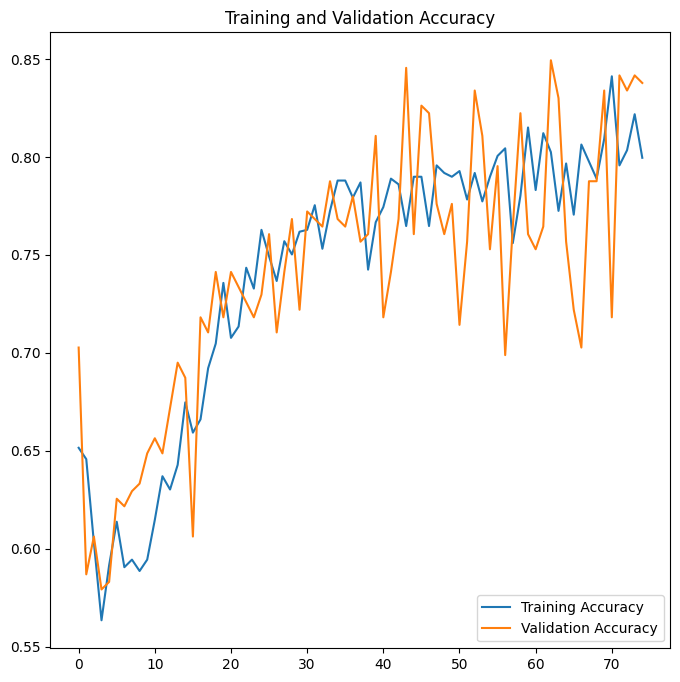

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eps)
plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

730 1061
[234.73140175640583, 333.759343624115]


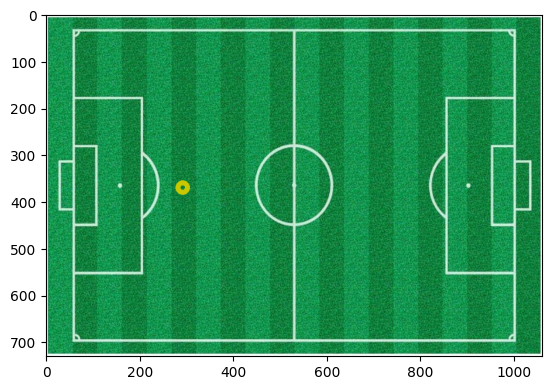

In [56]:
field = cv2.imread('field.png')
plt.imshow(field)
h, w, d = field.shape
print(h,w)
x = test_result[0]*w/hlf
unit_result = [test_result[0]*w/(2*hlf),h - test_result[1]*h/wf]
offset = [58,37]
cv2.circle(field,(int(offset[0]+unit_result[0]),int(offset[1]+unit_result[1])),10,(200,200,0),10)
plt.imshow(field)
print(unit_result)